# Otimização de  funções de benchmark utilizando Simulated Anealling e análise de dimensionalidade

### Rafael Brusiquesi Martins


## Definição das bibliotecas de utilização e implementação do algoritmo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from copy import deepcopy
style.use('seaborn')

In [2]:
class SimulatedAnealling:
    def __init__(self, dimension, initial_temperature, max_random_radius, low_boundaries=None, high_boundaries=None):
        self.dimension = dimension
        self.initial_temperature = initial_temperature
        self.max_random_radius = max_random_radius

        self.low_boundaries = np.full(self.dimension, -np.inf) if low_boundaries is None else low_boundaries
        self.high_boundaries = np.full(self.dimension, np.inf) if high_boundaries is None else high_boundaries
    
    def new_guess(self, guess):
        new_guess = deepcopy(guess)
        new_guess += self.max_random_radius * np.random.uniform(-1, 1, size=self.dimension)

        return new_guess
    
    def maximize(self, function, initial_guess, n_iterations=10000):
        temperature = self.initial_temperature

        guess = initial_guess
        function_value = function(guess)
        best_guess = deepcopy(guess)
        
        for i in range(n_iterations):
            new_guess = np.clip(self.new_guess(guess), self.low_boundaries, self.high_boundaries)
            new_function_value = function(new_guess)

            if new_function_value > function_value:
                guess = new_guess
                function_value = new_function_value
            
            else:
                criterion = np.exp(-(function_value - new_function_value)/temperature)
                
                if np.random.uniform() < criterion:
                    guess = new_guess
                    function_value = new_function_value
            
            if function_value > function(best_guess):
                best_guess = deepcopy(guess)

            temperature = self.initial_temperature / (i + 1)
        
        return best_guess
    
    def minimize(self, function, initial_guess, n_iterations=10000):
        negative_function = lambda x: -function(x)

        return self.maximize(negative_function, initial_guess, n_iterations)
    
    def multiple_restart_optimization(self, function, initial_guess, n_restarts, n_iterations=10000, operation='maximize'):
        if operation == 'maximize':
            ans = self.maximize(function, initial_guess, n_iterations=n_iterations)
            for i in range(n_restarts):
                ans = self.maximize(function, initial_guess=ans, n_iterations=n_iterations)

        elif operation == 'minimize':
            ans = self.minimize(function, initial_guess, n_iterations=n_iterations)
            for i in range(n_restarts):
                ans = self.minimize(function, initial_guess=ans, n_iterations=n_iterations)

        else:
            raise Exception('incorrect operation keyword')
        
        return ans


## Definindo uma função de benchmark multimodal para testar a robustez do algoritmo de Simulated Anealling

Ponto de mínimo da função: [0]*len(x)

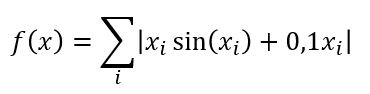

In [3]:
def f(x):
    return sum([abs(x_i*np.sin(x_i)+0.1*x_i) for x_i in x])

## Simulação

Construindo um objeto do tipo SimulatedAnealling e definindo parâmetros de temperatura, dimensão e raio máximo de deslocamento aleatório por etapa. Aplicando a otimização pelo número de iterações desejadas para um chute inicial fornecido. Testando inicialmente para 5 dimensões.

In [4]:
SA = SimulatedAnealling(
    dimension=5,
    initial_temperature=10000,
    max_random_radius=1 # tem a ver com o n de iterações ou talvez a temperatura
    )

ans = SA.minimize(f, initial_guess=np.ones(shape=SA.dimension), n_iterations=100000)
print(ans, f(ans))

[ 0.01451657  0.1982609   9.52571643 -0.05288051  0.10184175] 0.09087755873366181


Testando o modo de reinicialização iterativa de temperatura para aumentar a robustez e eficiência do algoritmo. utilizando o mesmo número de iterações totais (100*1000 = 100000)

In [5]:
ans = SA.multiple_restart_optimization(f, initial_guess=np.ones(shape=SA.dimension), n_restarts=100, n_iterations=1000, operation='minimize')
print(ans, f(ans))

[ 0.3718596  -3.14838217 -3.0652735   0.17070734 -0.1078613 ] 0.6282257422605542


Pode-se perceber, para os hiperparâmetros utilizados, que a função se aproxima mais do ponto ótimo com o uso da reinicialização iterativa.

## Efeito do aumento de dimensionalidade

In [6]:
optimum_values = []
for dimensions in range(1, 200):
    SA = SimulatedAnealling(
        dimension=dimensions,
        initial_temperature=10000,
        max_random_radius=1 # tem a ver com o n de iterações ou talvez a temperatura
        )
    ans = SA.multiple_restart_optimization(f, initial_guess=np.ones(shape=SA.dimension), n_restarts=10, n_iterations=1000, operation='minimize')
    print(f'dimensions:{dimensions}', f(ans))
    optimum_values.append(f(ans))

dimensions:1 5.90374309235979e-05
dimensions:2 0.012212038060619972
dimensions:3 0.2835594793450317
dimensions:4 0.8381188104805909
dimensions:5 1.006957663177178
dimensions:6 0.7543672896241358
dimensions:7 1.9804689608658486
dimensions:8 3.3198139336340677
dimensions:9 4.723957878658078
dimensions:10 6.1233293281057195
dimensions:11 8.744053883874335
dimensions:12 4.322445523403628
dimensions:13 8.486951333236899
dimensions:14 8.226854404472347
dimensions:15 6.254292188179511
dimensions:16 9.847740040042412
dimensions:17 11.175120131549498
dimensions:18 9.552389286037183
dimensions:19 5.851212592435161
dimensions:20 17.141992384959213
dimensions:21 14.939668031397126
dimensions:22 16.931270861899264
dimensions:23 16.145259623181563
dimensions:24 13.50140279057928
dimensions:25 15.790575296181109
dimensions:26 17.208212918933267
dimensions:27 19.14701330732702
dimensions:28 21.045959061052738
dimensions:29 22.547686047738466
dimensions:30 26.679627508071867
dimensions:31 21.1986437310

Plotando o valor do ponto ótimo encontrado pelo algoritmo em função de até 200 dimensões.

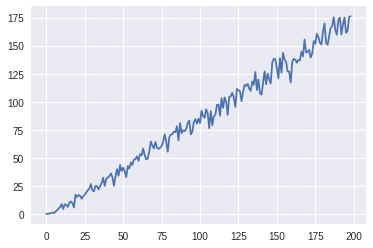

In [7]:
plot = plt.plot(optimum_values)

Pode-se perceber que o aumento da dimensionalidade do problema representa um grande desafio a ser tomado com relação aos algoritmos de otimização, pois o espaço de busca aumenta consideravelmente com o aumento do número de dimensões do problema, causando maior distância ao ponto de ótimo e mais estocasticidade do resultado do algoritmo, dificultando o encontro do ponto ótimo do problema, é o que se denomina "Maldição da Dimensionalidade". O qual deve ser avaliado com atenção, pois grande parte dos problemas de grande interesse atualmente, em geral, possuem dimensionalidade muito alta.